In [1]:
%load_ext autoreload
%autoreload

In [2]:
import sys
sys.path.append("../")

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
import shap
import lightgbm as lgb

from src.utils import load_fold
from src.evaluation import corr_score
from src.settings import *

plt.rcParams["figure.figsize"] = (16,9)

# Model Dev

In [41]:
folds = np.arange(1,10,1)

feature_cols =[col for col in train_df.columns if col not in non_train_cols]
target_col = ['Target']

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [46]:
from src.settings import lagged_periods, relative_periods

In [47]:
np.max(np.concatenate((lagged_periods, relative_periods)))

60

In [42]:
feature_cols

['Count',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'VWAP',
 'direct_return',
 'log_return',
 'high_low_ratio',
 'log_change_Count_1min',
 'log_change_Open_1min',
 'log_change_High_1min',
 'log_change_Low_1min',
 'log_change_Close_1min',
 'log_change_Volume_1min',
 'log_change_VWAP_1min',
 'log_change_Count_60min',
 'log_change_Open_60min',
 'log_change_High_60min',
 'log_change_Low_60min',
 'log_change_Close_60min',
 'log_change_Volume_60min',
 'log_change_VWAP_60min',
 'lag_1_min_direct_return',
 'lag_1_min_log_return',
 'lag_1_min_high_low_ratio',
 'lag_1_min_log_change_Count_1min',
 'lag_1_min_log_change_Open_1min',
 'lag_1_min_log_change_High_1min',
 'lag_1_min_log_change_Low_1min',
 'lag_1_min_log_change_Close_1min',
 'lag_1_min_log_change_Volume_1min',
 'lag_1_min_log_change_VWAP_1min',
 'lag_2_min_direct_return',
 'lag_2_min_log_return',
 'lag_2_min_high_low_ratio',
 'lag_2_min_log_change_Count_1min',
 'lag_2_min_log_change_Open_1min',
 'lag_2_min_log_change_High_1min',
 

In [38]:
# Load training data 
train_dir = '../data/gresearch/processed/fold_6/train/'
test_dir = '../data/gresearch/processed/fold_6/test/'

In [39]:
train_df = load_fold(train_dir)
test_df = load_fold(test_dir)

In [25]:
lgb_train_data = lgb.Dataset(train_df[feature_cols],
                             label=train_df[target_col])

In [26]:
param = {'objective': 'regression', 'metric': 'mae'}
num_round = 20

bst = lgb.train(param, lgb_train_data, num_round)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18870
[LightGBM] [Info] Number of data points in the train set: 1611716, number of used features: 74
[LightGBM] [Info] Start training from score 0.000013


In [29]:
pred = pd.DataFrame({'Asset_ID': train_df.Asset_ID,
                     'timestamp': train_df.timestamp})

pred['prediction'] = bst.predict(train_df[feature_cols])


test = train_df[['Target', 'Weight', 'timestamp', 'Asset_ID']].merge(
    pred, on=['timestamp', 'Asset_ID'], how='left').fillna(0)

score = corr_score(test.Target, test.prediction, test.Weight)
print(score)

0.12855137283961185


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Target', ylabel='prediction'>

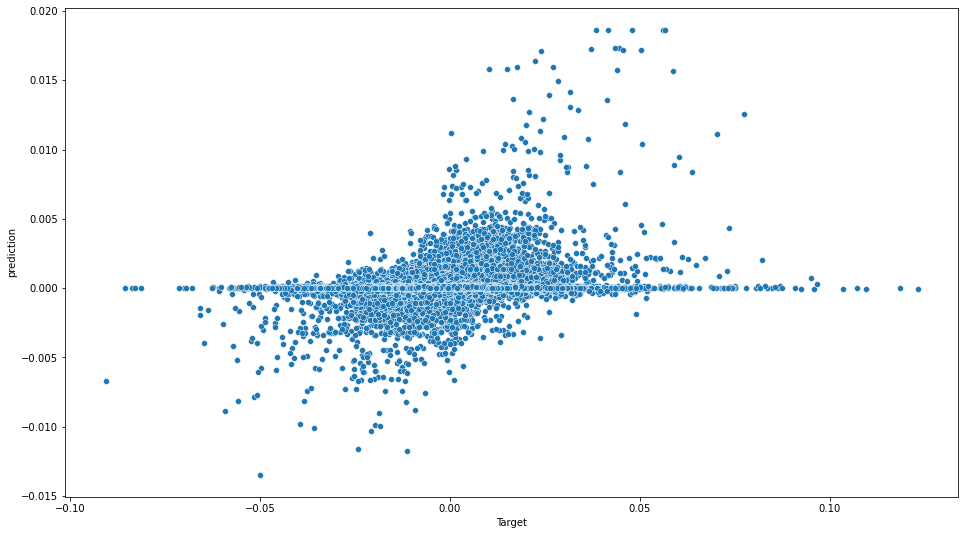

In [30]:
sns.scatterplot(test.Target, test.prediction)

In [31]:
# Out of sample
pred = pd.DataFrame({'Asset_ID': test_df.Asset_ID,
                     'timestamp': test_df.timestamp})

pred['prediction'] = bst.predict(test_df[feature_cols])


test = test_df[['Target', 'Weight', 'timestamp', 'Asset_ID']].merge(
    pred, on=['timestamp', 'Asset_ID'], how='left').fillna(0)

score = corr_score(test.Target, test.prediction, test.Weight)
print(score)

0.0035235858639027003


In [34]:
stats.pearsonr(test.Target,test.prediction)

(0.0030366706529196923, 0.009688902365309067)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Target', ylabel='prediction'>

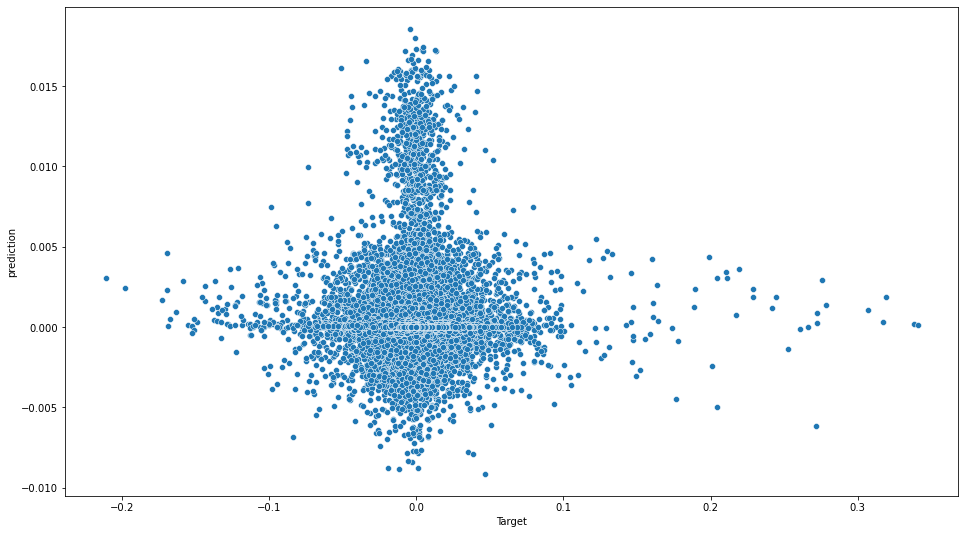

In [35]:
sns.scatterplot(test.Target, test.prediction)

In [36]:
np.corrcoef((test.Target,test.prediction))

array([[1.        , 0.00303667],
       [0.00303667, 1.        ]])

In [32]:
shap_values = shap.TreeExplainer(bst).shap_values(train_df[feature_cols])

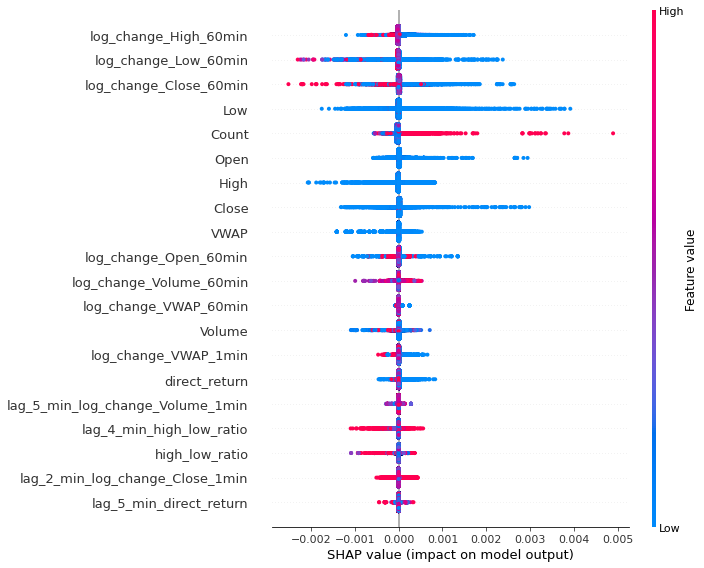

In [33]:
shap.summary_plot(shap_values, train_df[feature_cols])